#### Imports

In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import transform


#### Fonctions utilitaires pour parcourir les images

In [2]:
common_path = "./chest_Xray"
images_files = os.listdir(common_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    for subfolder in subfolders:
        for category in categories:
            folder_path = os.path.join(common_path, subfolder, category)
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path,file_name)
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                img_callback(img, category, file_name)  # Pass file_name as an additional argument

In [35]:
all_images = []
all_categories = []

datasetX = []
datasetY = []

image_size = (200, 200)

def load_datasets(img, category, file_name):
    if category == "PNEUMONIA":
        if "virus" in file_name:
            category = "VIRUS PNEUMONIA"
        elif "bacteria" in file_name:
            category = "BACTERIA PNEUMONIA"
    else:
        category = "NORMAL"
    
    new_img = cv2.resize(img, image_size)
    all_images.append(new_img)
    all_categories.append(category)

browse_imgs(load_datasets)

##### Doubler le dataset d'images NORMAL

In [36]:
# Définir une fonction pour effectuer une rotation d'image
def rotate_image(image, angle):
    return transform.rotate(image, angle)

# Définir une fonction pour effectuer un retournement horizontal d'image
def flip_image(image):
    return image[:, ::-1]

normal_indice = []
print("Normal indices size : ", len(normal_indice))

# Créer une liste pour stocker les indices des images "NORMAL"
normal_indice = [i for i, category in enumerate(all_categories) if category == "NORMAL"]

print("Normal indices size : ", len(normal_indice))

# Pour chaque image "NORMAL"...
for i in normal_indice:
    img = all_images[i]

    # Effectuer une rotation de 20 degrés, redimensionner l'image et l'ajouter à la liste de toutes les images
    rotated_img = rotate_image(img, 20)
    resized_rotated_img = cv2.resize(rotated_img, image_size)
    all_images.append(resized_rotated_img)
    all_categories.append("NORMAL")

    # Effectuer un retournement horizontal, redimensionner l'image et l'ajouter à la liste de toutes les images
    flipped_img = flip_image(img)
    resized_flipped_img = cv2.resize(flipped_img, image_size)
    all_images.append(resized_flipped_img)
    all_categories.append("NORMAL")

# Convert the list of all images to a numpy array
datasetX = np.array(all_images)

def use_all_dataset():
    global datasetX, datasetY
    datasetX = np.array(all_images)
    datasetY = np.array(all_categories)

use_all_dataset()
print("Dataset all shape : ", datasetX.shape)

Normal indices size :  0
Normal indices size :  1583
Dataset all shape :  (9022, 200, 200)


#### Doubler le datase d'images "virus pneumonia"

In [37]:
# # Créer une liste pour stocker les indices des images "VIRUS PNEUMONIA"
# virus_pneumonia_indices = [i for i, category in enumerate(all_categories) if category == "VIRUS PNEUMONIA"]

# print("VIRUS PNEUMONIA indices size : ", len(virus_pneumonia_indices))

# # Pour chaque image "VIRUS PNEUMONIA"...
# for i in virus_pneumonia_indices:
#     img = all_images[i]

#     # Effectuer une rotation de 20 degrés, redimensionner l'image et l'ajouter à la liste de toutes les images
#     rotated_img = rotate_image(img, 20)
#     resized_rotated_img = cv2.resize(rotated_img, image_size)
#     all_images.append(resized_rotated_img)
#     all_categories.append("VIRUS PNEUMONIA")

#     # Effectuer un retournement horizontal, redimensionner l'image et l'ajouter à la liste de toutes les images
#     flipped_img = flip_image(img)
#     resized_flipped_img = cv2.resize(flipped_img, image_size)
#     all_images.append(resized_flipped_img)
#     all_categories.append("VIRUS PNEUMONIA")

# # Convertir la liste de toutes les images en un tableau numpy
# datasetX = np.array(all_images)
# datasetY = np.array(all_categories)  # Assurez-vous que cette conversion est nécessaire pour votre cas d'utilisation

# print("Dataset all shape : ", datasetX.shape)

VIRUS PNEUMONIA indices size :  1493
Dataset all shape :  (12008, 200, 200)


#### Doubler le dataset d'images "BACTERIA PNEUMONIA"

In [38]:
# # Créer une liste pour stocker les indices des images "BACTERIA PNEUMONIA"
# bacteria_pneumonia_indices = [i for i, category in enumerate(all_categories) if category == "BACTERIA PNEUMONIA"]

# print("BACTERIA PNEUMONIA indices size : ", len(bacteria_pneumonia_indices))

# # Pour chaque image "BACTERIA PNEUMONIA"...
# for i in bacteria_pneumonia_indices:
#     img = all_images[i]

#     # Effectuer une rotation de 20 degrés, redimensionner l'image et l'ajouter à la liste de toutes les images
#     rotated_img = rotate_image(img, 20)
#     resized_rotated_img = cv2.resize(rotated_img, image_size)
#     all_images.append(resized_rotated_img)
#     all_categories.append("BACTERIA PNEUMONIA")

#     # Effectuer un retournement horizontal, redimensionner l'image et l'ajouter à la liste de toutes les images
#     flipped_img = flip_image(img)
#     resized_flipped_img = cv2.resize(flipped_img, image_size)
#     all_images.append(resized_flipped_img)
#     all_categories.append("BACTERIA PNEUMONIA")

# # Convertir la liste de toutes les images en un tableau numpy
# datasetX = np.array(all_images)
# datasetY = np.array(all_categories)

# print("Dataset all shape : ", datasetX.shape)

BACTERIA PNEUMONIA indices size :  2780
Dataset all shape :  (17568, 200, 200)


#### Fonction Display distribution

In [39]:
def display_distribution(ytrain, testy, label_encoder):
    categories = ['NORMAL', 'VIRUS PNEUMONIA', 'BACTERIA PNEUMONIA']
    # Convert numeric labels back to categorical for display
    ytrain_cat = label_encoder.inverse_transform(ytrain)
    testy_cat = label_encoder.inverse_transform(testy)
    
    test_counts = [np.count_nonzero(testy_cat == category) for category in categories]
    train_counts = [np.count_nonzero(ytrain_cat == category) for category in categories]
    
    # Plot the distribution graphs
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))  # Adjusted subplot count to 2 as only two plots are needed
    ax[0].bar(categories, train_counts)
    ax[0].set_title("Train Distribution")
    ax[1].bar(categories, test_counts)  # Adjusted index to 1 for the second plot
    ax[1].set_title("Test Distribution")
    plt.show()

#### Machine Learning

##### Resize and Flatten Transformers

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [28]:
class ResizeImageTransformer():
    def __init__(self, size):
        self.size = size
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = np.array([cv2.resize(img, self.size) for img in X])
        return X

class FlattenTransformer():    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.reshape(len(X), -1)
        return X

In [40]:
general_scoring = {
    "recall": make_scorer(recall_score, average='macro'),
    "precision": make_scorer(precision_score, average='macro'),
    # "f1": make_scorer(f1_score, average='macro')
}

In [45]:
def cross_val(model, scoring, nb_folds=3, verbose=3):
    res = cross_validate(model, datasetX, datasetY, cv=nb_folds, scoring=scoring, error_score="raise", return_train_score=True, verbose=verbose)
    res.pop("fit_time")
    res.pop("score_time")
    return res

In [46]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=15, weights='distance', algorithm='brute')
)

# Encoder les étiquettes
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(all_categories)
datasetY = np.array(numeric_labels)

print("numeric labels : ", numeric_labels)
print("Numeric labels shape : ", datasetY.shape)

def use_all_dataset():
    global datasetX, datasetY
    datasetX = np.array(all_images)
    datasetY = np.array(numeric_labels)

scores = cross_val(model, general_scoring)
df = pd.DataFrame(scores)
df

numeric labels :  [1 1 1 ... 0 0 0]
Numeric labels shape :  (17568,)
[CV] END  precision: (train=1.000, test=0.736) recall: (train=1.000, test=0.675) total time=  28.7s
[CV] END  precision: (train=1.000, test=0.727) recall: (train=1.000, test=0.700) total time=  31.0s
[CV] END  precision: (train=1.000, test=0.757) recall: (train=1.000, test=0.678) total time=  26.8s


,test_recall,train_recall,test_precision,train_precision
0,0.674646,1.0,0.736024,1.0
1,0.700245,1.0,0.727256,1.0
2,0.678453,1.0,0.757440,1.0


In [49]:
print(df.mean())

test_recall        0.684448
train_recall       1.000000
test_precision     0.740240
train_precision    1.000000
dtype: float64


In [33]:
trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)

print("Train X shape : ", trainx.shape)
print("Train Y shape : ", trainy.shape)
print("Test X shape : ", testx.shape)
print("Test Y shape : ", testy.shape)

Train X shape :  (9606, 200, 200)
Train Y shape :  (9606,)
Test X shape :  (2402, 200, 200)
Test Y shape :  (2402,)


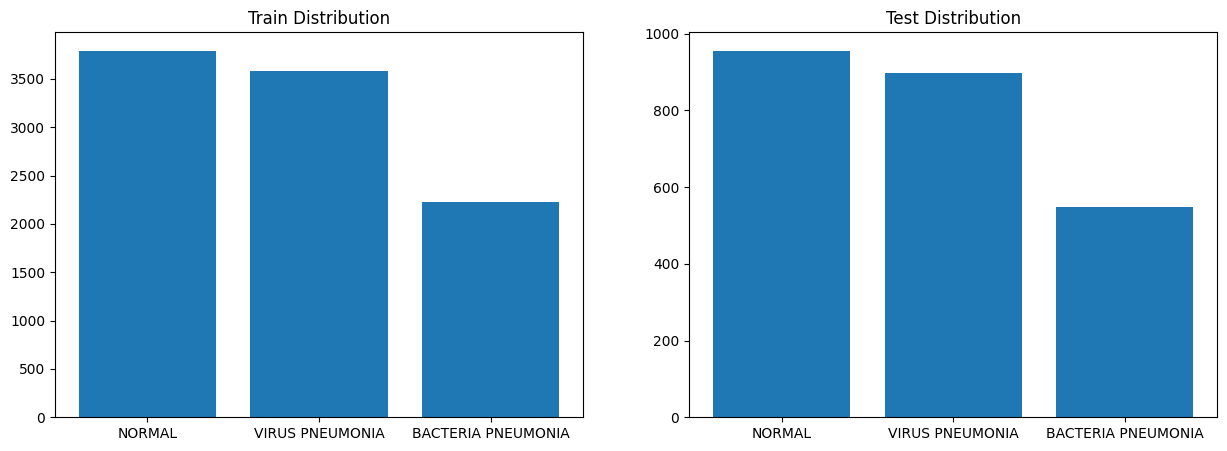

Recall (macro) :  0.7992747722406522
Precision (macro) :  0.7920018434724317


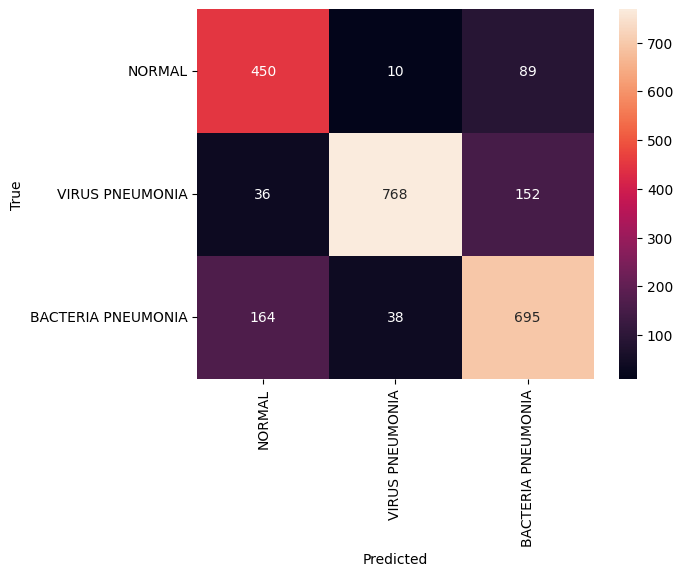

In [50]:
model.fit(trainx, trainy)

print(trainx.shape)

y_pred = model.predict(testx)

display_distribution(trainy, testy, label_encoder)

recall = recall_score(testy, y_pred, average='macro')
precision = precision_score(testy, y_pred, average='macro')
print("Recall (macro) : ", recall)
print("Precision (macro) : ", precision)

labels = ['NORMAL', 'VIRUS PNEUMONIA', 'BACTERIA PNEUMONIA']

cm = confusion_matrix(testy, y_pred)

sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Classification Report

In [51]:
from sklearn.metrics import classification_report

# Génération du rapport de classification
report = classification_report(testy, y_pred, target_names=labels)
print(report)

                    precision    recall  f1-score   support

            NORMAL       0.69      0.82      0.75       549
   VIRUS PNEUMONIA       0.94      0.80      0.87       956
BACTERIA PNEUMONIA       0.74      0.77      0.76       897

          accuracy                           0.80      2402
         macro avg       0.79      0.80      0.79      2402
      weighted avg       0.81      0.80      0.80      2402



#### GridSearchCV

In [17]:
param_grid = {
    'kneighborsclassifier__n_neighbors': np.arange(1, 20, 1),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__algorithm': ['brute', 'auto'] # , 'ball_tree', 'kd_tree'
}

In [18]:
model_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=4, scoring=make_scorer(recall_score, average='macro'),
    verbose=3)
use_all_dataset()
model_grid_search.fit(datasetX, datasetY)
model_grid_search.best_params_

Fitting 4 folds for each of 76 candidates, totalling 304 fits
[CV 1/4] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.629 total time=   4.8s
[CV 2/4] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.630 total time=   5.0s
[CV 3/4] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.736 total time=   4.6s
[CV 4/4] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=uniform;, score=0.702 total time=   4.4s
[CV 1/4] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=distance;, score=0.629 total time=   4.3s
[CV 2/4] END kneighborsclassifier__algorithm=brute, kneighborsclassifier__n_neighbors=1, kneighborsclassifier__weights=distance;, score=0

recall :  1.0
precision :  1.0
f1score :  1.0


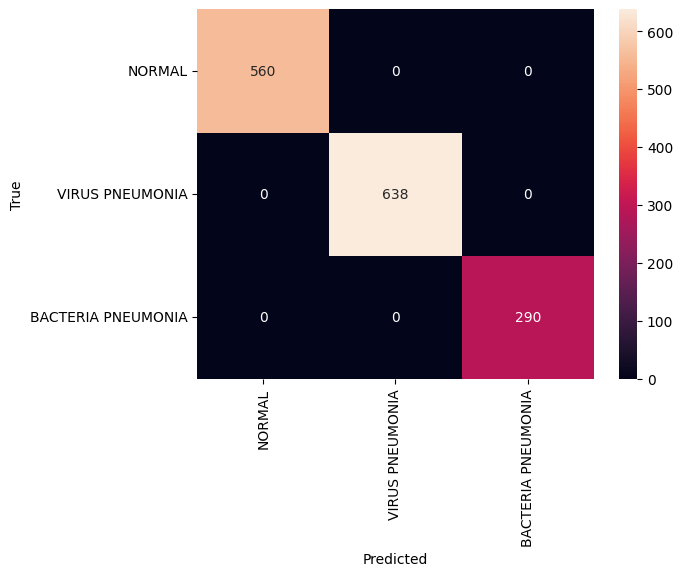

In [33]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, average='macro')
precision = precision_score(testy, y_pred, average='macro')
f1score = f1_score(testy, y_pred, average='macro')
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

labels = ['NORMAL', 'VIRUS PNEUMONIA', 'BACTERIA PNEUMONIA']  # Remplacez 'Label1', 'Label2', 'Label3' par vos vrais labels

# Calcul de la matrice de confusion
cm = confusion_matrix(testy, y_pred)

# Affichage de la matrice de confusion avec les vrais labels
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [50]:
model.get_params()

{'memory': None,
 'steps': [('resizeimagetransformer',
   <__main__.ResizeImageTransformer at 0x25ed8f5f110>),
  ('flattentransformer', <__main__.FlattenTransformer at 0x25ed901dfa0>),
  ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=11))],
 'verbose': False,
 'resizeimagetransformer': <__main__.ResizeImageTransformer at 0x25ed8f5f110>,
 'flattentransformer': <__main__.FlattenTransformer at 0x25ed901dfa0>,
 'kneighborsclassifier': KNeighborsClassifier(n_neighbors=11),
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 11,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

#### Learning Curve

[learning_curve] Training set sizes: [ 640 1280 1921 2561 3202 3842 4482 5123 5763 6404]
[CV] END ..................., score=(train=1.000, test=0.719) total time=   2.1s
[CV] END ..................., score=(train=1.000, test=0.745) total time=   2.7s
[CV] END ..................., score=(train=1.000, test=0.758) total time=   3.7s
[CV] END ..................., score=(train=1.000, test=0.760) total time=   4.3s
[CV] END ..................., score=(train=1.000, test=0.767) total time=   5.5s
[CV] END ..................., score=(train=1.000, test=0.773) total time=   6.0s
[CV] END ..................., score=(train=1.000, test=0.780) total time=   7.3s
[CV] END ..................., score=(train=1.000, test=0.790) total time=   8.1s
[CV] END ..................., score=(train=1.000, test=0.789) total time=   8.6s
[CV] END ..................., score=(train=1.000, test=0.792) total time=  10.0s
[CV] END ..................., score=(train=1.000, test=0.717) total time=   2.1s
[CV] END ...........

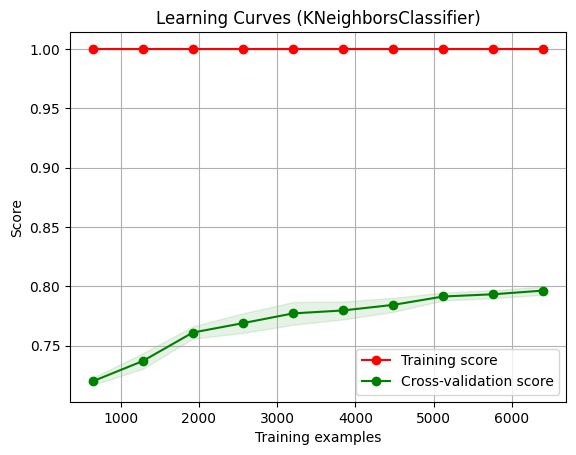

In [52]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10), verbose=3):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Tracer les courbes d'apprentissage
plot_learning_curve(model, "Learning Curves (KNeighborsClassifier)", trainx, trainy, cv=3, verbose=3)
plt.show()